<a href="https://colab.research.google.com/github/wuyi010/model/blob/main/mask_rcnn_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
root = '/content/drive/MyDrive/segmentation'
import os
if not os.path.isdir(root):
  os.mkdir(root)
os.chdir(root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
target_directory = '/content/drive/MyDrive/segmentation/mask_rcnn'
os.chdir(target_directory)

In [ ]:
!python -m pip install -r /content/drive/MyDrive/segmentation/mask_rcnn/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/content/drive/MyDrive/segmentation/mask_rcnn
/content/drive/MyDrive/segmentation/mask_rcnn
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using cuda:0 device.
inference+NMS time: 0.1965503692626953


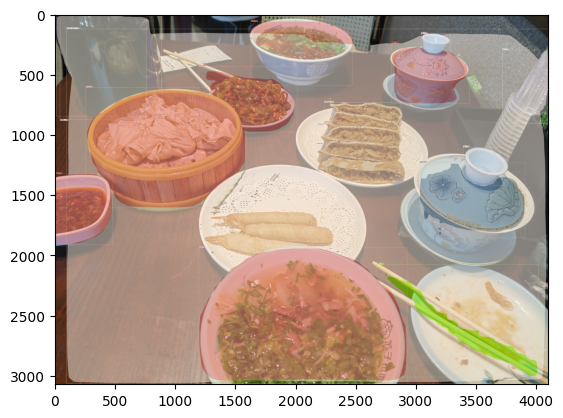

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 显示+设置当前目录
import os
print(os.getcwd())
target_directory  = '/content/drive/MyDrive/segmentation/mask_rcnn'
os.chdir(target_directory)
print(os.getcwd())

# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if target_directory not in sys.path:
  sys.path.append(target_directory)

%load_ext autoreload
%autoreload 2
"""
这段代码的作用是将 /content/faster_rcnn_env/faster_rcnn
目录添加到Python解释器的搜索路径中，以便可以导入该目录中的模块和文件。
sys.path 是一个包含 Python 解释器搜索模块的路径列表。通过将目录添加到 sys.path 中，
你可以告诉 Python 解释器在这些路径中查找模块。
%load_ext autoreload 是 IPython 魔术命令，用于启用自动重新加载扩展。
当你修改了导入的模块或文件后，使用 %autoreload 2
可以自动重新加载最新的代码，以便在下一次调用时生效，无需手动重新启动内核。
这样做的好处是，在你修改了代码后，可以直接运行调试或测试代码，无需手动重启内核或重新导入模块。
请注意，确保路径 /content/faster_rcnn_env/faster_rcnn 是正确的，并根据你的实际情况进行相应的调整。
"""

from backbone import feature_pyramid_network
from backbone import resnet50_fpn_model

from network_files import boxes
from network_files import det_utils
from network_files import faster_rcnn_framework
from network_files import image_list
from network_files import mask_rcnn
from network_files import roi_head
from network_files import rpn_function
from network_files import transform

from train_utils import coco_eval
from train_utils import coco_utils
from train_utils import distributed_utils
from train_utils import group_by_aspect_ratio
from train_utils import train_eval_utils

import draw_box_utils
import my_dataset_coco
import my_dataset_voc
import plot_curve
import predict
import train
import train_multi_GPU
import transforms
import validation

import os
import time
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from network_files import MaskRCNN
from backbone import resnet50_fpn_backbone
from draw_box_utils import draw_objs


def create_model(num_classes, box_thresh=0.5):
    backbone = resnet50_fpn_backbone()
    model = MaskRCNN( backbone,
               num_classes=num_classes,
               rpn_score_thresh=box_thresh,
               box_score_thresh=box_thresh
             )

    return model


def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()


def main():
    num_classes = 90  # 不包含背景
    box_thresh = 0.5
    weights_path = "/content/drive/MyDrive/segmentation/mask_rcnn/backbone/mask_rcnn_weights.pth"
    img_path = "/content/12.jpg"
    label_json_path = '/content/drive/MyDrive/segmentation/mask_rcnn/coco91_indices.json'

    # get devices
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    # create model
    model = create_model(num_classes=num_classes + 1, box_thresh=box_thresh)

    # load train weights
    assert os.path.exists(weights_path), "{} file dose not exist.".format(weights_path)
    weights_dict = torch.load(weights_path, map_location='cpu')
    weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
    model.load_state_dict(weights_dict)
    model.to(device)

    # read class_indict
    assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
    with open(label_json_path, 'r') as json_file:
        category_index = json.load(json_file)

    # load image
    assert os.path.exists(img_path), f"{img_path} does not exits."
    original_img = Image.open(img_path).convert('RGB')

    # from pil image to tensor, do not normalize image
    data_transform = transforms.Compose([transforms.ToTensor()])
    img = data_transform(original_img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    model.eval()  # 进入验证模式
    with torch.no_grad():
        # init
        img_height, img_width = img.shape[-2:]
        init_img = torch.zeros((1, 3, img_height, img_width), device=device)
        model(init_img)

        t_start = time_synchronized()
        predictions = model(img.to(device))[0]
        t_end = time_synchronized()
        print("inference+NMS time: {}".format(t_end - t_start))

        predict_boxes = predictions["boxes"].to("cpu").numpy()
        predict_classes = predictions["labels"].to("cpu").numpy()
        predict_scores = predictions["scores"].to("cpu").numpy()
        predict_mask = predictions["masks"].to("cpu").numpy()
        predict_mask = np.squeeze(predict_mask, axis=1)  # [batch, 1, h, w] -> [batch, h, w]

        if len(predict_boxes) == 0:
            print("没有检测到任何目标!")
            return

        plot_img = draw_objs(original_img,
                    boxes=predict_boxes,
                    classes=predict_classes,
                    scores=predict_scores,
                    masks=predict_mask,
                    category_index=category_index,
                    line_thickness=1,
                    font='arial.ttf',
                    font_size=30)
        plt.imshow(plot_img)
        plt.show()
        # 保存预测的图片结果
        plot_img.save("test_result.jpg")

        from google.colab import files
        # 假设图片变量为img
        plot_img.save('test_result.jpg')  # 保存为image.jpg
        files.download('test_result.jpg')  # 下载保存的图片文件


if __name__ == '__main__':
    main()
